# TensoRF Color Variance

## Imports

In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models.tensoRF import TensorVMSplit

/Users/alexanderkorte/miniforge3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_default_dtype(torch.float32)
torch.manual_seed(20211202)
np.random.seed(20211202)

## Load Model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load('trained_models/tensorf_trex_VM.th', map_location=device)
kwargs = ckpt['kwargs']
kwargs.update({'device': device})
tensorf = TensorVMSplit(**kwargs)
tensorf.load(ckpt)

aabb tensor([-1.5000, -1.6700, -1.0000,  1.5000,  1.6700,  1.0000])
grid size [706, 786, 471]
sampling step size:  tensor(0.0021)
sampling number:  2311
pos_pe 6 view_pe 0 fea_pe 0
MLPRender_Fea(
  (mlp): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)


## Find Color Variance

In [4]:
ray = torch.tensor([[ 1.2144,  1.4356, -1.0000, -0.5201, -0.6335,  2.0000]]).to(device) # x,y,z, dx,dy,dz
ray[:, 3:6]

tensor([[-0.5201, -0.6335,  2.0000]])

In [5]:
with torch.no_grad():
    tensorf.eval()
    output = tensorf.forward(ray)

rgb_map, depth, rgb, sigma, xyz_sampled = output

rgb = rgb[0].cpu().numpy()
sigma = sigma[0].cpu().numpy()
xyz_sampled = xyz_sampled[0].cpu().numpy()


## Graphical Data Views

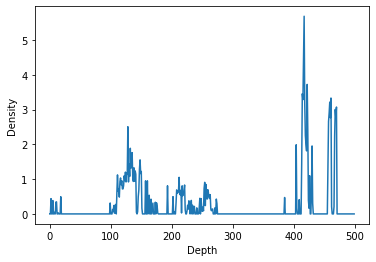

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

ax.plot(sigma[:500])

plt.show()

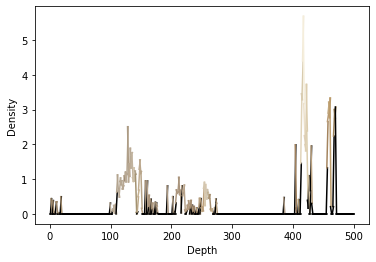

In [7]:
fig_col = plt.figure()
ax = fig_col.add_subplot(111)

ax.set_xlabel('Depth')
ax.set_ylabel('Density')

# ax.set_ylim(0, 1)
for i in range(len(sigma[:500])):
    ax.plot([i,i+2],sigma[i:i+2],color=(tuple(rgb[i])))

plt.show()

In [8]:
variance_depth = 0
xyz = xyz_sampled[variance_depth]

sampled_ray = ray[0].cpu().numpy()
testing_rays = []
size = 90
for i in range(size**2):
    testing_rays.append([xyz[0], xyz[1], xyz[2],(((i%size)-45)/360)+sampled_ray[3], ((int(i/size)-45)/360)+sampled_ray[4], sampled_ray[5]])

testing_rays = torch.tensor(testing_rays, dtype=torch.float32).to(device)

with torch.no_grad():
    tensorf.eval()
    output = tensorf(testing_rays)

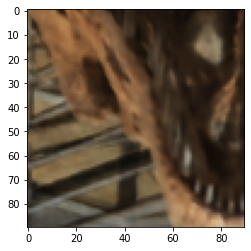

In [9]:
rgb_map = output[0].cpu().numpy()
rgb_map = rgb_map.reshape(size,size,3)
imgplot = plt.imshow(rgb_map)

In [10]:
variance_depth = 425
xyz = xyz_sampled[variance_depth]
xyz = torch.tensor(xyz).to(device).view(1,3)

sampled_ray = ray[0].cpu().numpy()
testing_views = []
size = 90
for i in range(size**2):
    testing_views.append([(((i%size)-45)/360)+sampled_ray[3], ((int(i/size)-45)/360)+sampled_ray[4], sampled_ray[5]])

testing_views = torch.tensor(testing_views, dtype=torch.float32).to(device)

variance_map = []
with torch.no_grad():
    tensorf.eval()
    for view in testing_views:
        testing_view = torch.tensor(view).to(device).view(1,3)
        variance_map.append(tensorf.get_variance(xyz, testing_view)[0].cpu().numpy())
    variance_map = np.array(variance_map)

/var/folders/pj/pdfdfscs3hjg6dyzhnb84n_80000gn/T/ipykernel_8732/3562219289.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_view = torch.tensor(view).to(device).view(1,3)


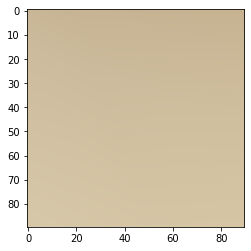

In [11]:
variance_map = variance_map.reshape(size,size,3)
imgplot = plt.imshow(variance_map)

In [12]:
from IPython.display import display, HTML

rays0 = np.load('rays0.npy')
df = pd.DataFrame(rays0)
display(df)
print(rays0[0][0] - rays0[1][0])
print(rays0[1][0] - rays0[2][0])

,0,1,2,3,4,5
0,1.325839,1.437004,-1.0,-0.517538,-0.633485,2.0
1,1.324109,1.437130,-1.0,-0.517578,-0.633482,2.0
2,1.322378,1.437256,-1.0,-0.517617,-0.633479,2.0
3,1.320647,1.437382,-1.0,-0.517656,-0.633476,2.0
4,1.318915,1.437508,-1.0,-0.517695,-0.633473,2.0
...,...,...,...,...,...,...
4091,1.223205,1.434949,-1.0,-0.519868,-0.633531,2.0
4092,1.221455,1.435075,-1.0,-0.519907,-0.633528,2.0
4093,1.219704,1.435202,-1.0,-0.519947,-0.633526,2.0
4094,1.217952,1.435328,-1.0,-0.519987,-0.633523,2.0


0.001730442
0.0017309189


(4096, 3)


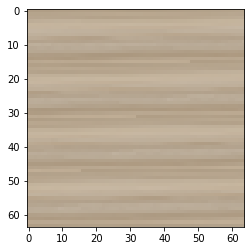

In [13]:
with torch.no_grad():
    tensorf.eval()
    output = tensorf.forward(torch.tensor(rays0, dtype=torch.float32).to(device))

rgb_map = output[0].cpu().numpy()
print(rgb_map.shape)
rgb_map = rgb_map.reshape(64,64,3)
imgplot = plt.imshow(rgb_map)